# Service Provider Reputation Systems: A Model

Uber, Airbnb, and other "sharing economy" platforms use reputations systems in which customers rate service providers, and service providers rate customers. Rating sites such as Yelp and TripAdvisor also rely on customer ratings to provide recommendations of service providers. This investigation focuses on customer ratings of service providers, as even when each party can rate the other, service providers have most to lose.

Two seemingly contradictory observations have emerged from these systems:
1. The systems show a Lake Woebegon effect, in which average ratings are very high. While ratings of Netflix movies, for example, peak around 3.5 out of 5, Uber drivers can be "deactivated" (fired) if their rating slips below 4.6 out of 5. This "J-curve" distribution suggests that customers treat reviews as a courtesy, rather than as an opportunity for objective assessment. Rather like a guest book, customers leave nice comments or say nothing at all.
2. Service providers fear the judgement of vanished customers (a Panopticon effect). They are very apprehensive that ratings given for the most frivolous of reasons may wreck their earnings opportunities, either by outright removal from a platform or by pushing them down the rankings in search recommendations, so rendering them invisible.

The Lake Woebegon effect suggests that rating systems are useless in that they fail to discriminate between good and bad service providers, a suggestion held up by recent empirical research. The Panopticon effect suggests that rating systems may be effective, by inducing a customer-pleasing attitude in service providers.

This investigation creates a model of behaviour under reputation systems that incorporates both the courtesy-driven Lake Woebegon effect and the judgement-driven Panopticon effect, and uses this model to explore issues such as whether reputation systems are fair, whether they are beneficial to service providers, and what kinds of behaviour they reward on the part of customers and service providers.

## Jupyter notebooks

This document is a Jupyter notebook (previously called an iPython notebook). The code for the model is included as part of the document, and the graphs that show the results are generated using the code in the document. If you want to reproduce or extend this model, you can save the notebook, install the right packages in a Python distribution, and run it on your own computer. In addition to the requirements for Jupyter, you will need to install the following packages in a Python 3 environment.

In [1]:
%matplotlib inline

# imports
import random # random number generation: part of the standard python distribution
import numpy as np # numerical libraries used by matplotlib
import matplotlib # plotting libraries
import matplotlib.pyplot as plt # more plotting libraries
import pandas as pd # data analysis library

## The Model Reputation System

There is a difference between rating movies and rating people: when we watch a movie the relationship is one way (the movie does not interact with us), but when we interact with others we enter into a two-way relationship. In some cases this relationship is brief and not likely to be repeated: taking a taxi or an Uber ride, eating in a fast-food restaurant in a city you are passing through. In other cases the relationship is richer and repeated: a stay at a Bed & Breakfast or an Airbnb (in a case where the host is present) may extend over days; a regular customer at a restaurant may get to know the staff; a relationship with a hairdresser or car mechanic may extend over years.

The results from reputation systems show that the richer the customer-service provider relationship, the more likely the reputation system is to show a high average rating. The rating is, in effect, one part of the customer-service provider relationship rather than a "drive-by" review.

### A repeated prisoner's dilemma model

The rating system is a simple thumbs-up, thumbs-down system in which the customer rates the provider after each exchange. Each exchange, in turn, is made up of multiple interactions.

I model an exchange between a customer and service provider ("provider" for short) as a repeated prisoner's dilemma (RPD), consisting of a number of interactions. The number of interactions in the RPD is a parameter: a single game of PD mimics the one-time interaction of a cab ride, a multiple-round PD mimics the extended and reciprocal relationship of a long-time relationship (hair-dresser, regular restaurant), or a rich one-time relationship (B&B).

In each interaction, the provider has the opportunity to provide the best service they can ("co-operate") or to provide lazy service ("defect"). The customer has the opportunity to help the service provider by engaging in a dialog. 

Each customer has a choice of two strategies:
- Tit-for-tat (reciprocal): this strategy is a reciprocal strategy that seeks to encourage co-operative behaviour between customer and service-provider. The customer gives a thumbs-up review on receiving a sincere effort from the provider, and a thumbs-down if the provider was lazy. The customer reviews are based on the provider's *effort* (this is a relationship) not on the provider's skill.
- Grim (entitled): this strategy is to give a thumbs-up if the provider puts in a full effort, until the provider is lazy. After that, the customer judges the provider to be sub-par and provides a thumbs-down review, no matter what. The customer is believes they are *entitled* to full effort on each and every interaction.
(QUESTION: Have I implemented "Grim" or "Defect")

Each provider also has a choice of two strategies:
- Tit-for-tat (reciprocal): the provider exerts themselves if the customer was co-operative in the previous interaction, and provides sloppy service if the customer was critical (defected).
- Cooperate (servile): the provider is servile (or "customer is always right"), putting in full effort no matter how demanding the customer is.

# Code walkthrough

Here is the implementation of the model, annotated. If you are not interesed in this, just skip to the next section.

## Parameters

Start with some constants that define the various things used elsewhere, in an attempt to make the rest of the code more legible.

In [2]:
# A constant for each actor type: customer and provider
ACTOR_TYPE_CUSTOMER = 0
ACTOR_TYPE_PROVIDER = 1

# Prisoner's dilemma strategies
STRATEGY_T4T = "T4T"
STRATEGY_GRIM = "Grim"
STRATEGY_DEFECT = "Defect"
STRATEGY_COOPERATE = "Cooperate"

# Prisoner's dilemma choices: co-operate or defect
CHOICE_COOPERATE = 0
CHOICE_DEFECT = 1

# The customer can give a thumbs-up or thumbs down rating of the provier
RATING_THUMBS_UP = 1.0
RATING_THUMBS_DOWN = -1.0

# The payoffs in the prisoner's dilemma. 
PAYOFF_C_VERSUS_C = 1.0
PAYOFF_C_VERSUS_D = 0.0
PAYOFF_D_VERSUS_C = 1.5
PAYOFF_D_VERSUS_D = 0.5

# The initial reputation of the provider
REPUTATION_DEFAULT = 0.0

# An actor

Each customer or provider is an actor. Each actor is represented by an Actor() object, which carries their type (ACTOR_TYPE_CUSTOMER or ACTOR_TYPE_PROVIDER), their strategy, and other information about them.

The Actor() class also has a method called choice() which implements the actor's strategy in any exchange (set of interactions). You will see that the strategy is to choose CHOICE_COOPERATE or CHOICE_DEFECT based on the history of the exchange. There is also a random noise added to represent misunderstanding. The proportion of interactions in which the choice is made randomly is configurable, below.

In [3]:
class Actor():
       
    def __init__(self, actor_strategy):
        self.strategy = actor_strategy
        # Initialize
        self.seen_defect = False
        self.utility = 0.0
        self.exchanges = 0.0
        self.previous_choice = None
        self.exchange_score = 0 # score in a current exchange
            
    def choose(self, prev_opponent_choice, noise_fraction):
        # This is the actor's strategy for prisoner's dilemma, and returns
        # either CHOICE_COOPERATE or CHOICE_DEFECT.
        # Currently, Tit-for-Tat, Grim, and "Always co-operate" are implemented
        # A random noise is also added
        
        # The choice depends on whether the actor has seen their partner defect or not
        # Here, the seen_defect flag gets set whenever the partner defects
        # (it never gets reset to False)
        if prev_opponent_choice == CHOICE_DEFECT:
            self.seen_defect = True
        
        # A tit-for-tat player (customer or provider) co-operates on the first move
        # and then does whatever their partner did on the previous move, repaying
        # co-operation with co-operation and defection with defection.
        if self.strategy == STRATEGY_T4T:
            if prev_opponent_choice is None:
                choice = CHOICE_COOPERATE
            else:
                choice = prev_opponent_choice
        # Grim is a customer strategy. It co-operates until the provider defects, 
        # after which it defects no matter what the partner does
        elif self.strategy == STRATEGY_GRIM:
            if self.seen_defect == True:
                choice = CHOICE_DEFECT
            else:
                choice = CHOICE_COOPERATE
        # Co-operate is a provider strategy: the customer is always right - put out
        # your best effort at all times. This is also called "servile" behaviour.
        elif self.strategy == STRATEGY_COOPERATE:
            choice = CHOICE_COOPERATE
        # DEFECT is a customer strategy. Always find something to criticize.
        elif self.strategy == STRATEGY_DEFECT:
            choice = CHOICE_DEFECT
        
        # Notwithstanding the above, a fraction of choices are random, for both 
        # customer and provider. This represents misunderstanding and prevents
        # artifical fragile equilibria from playing too big a part in the outcome
        if random.random() < noise_fraction:
            if random.random() < 0.5:
                choice = CHOICE_COOPERATE
            else:
                choice = CHOICE_DEFECT
        
        return choice

class Customer(Actor):

    def __init__(self, strategy):
        Actor.__init__(self, strategy)
        self.actor_type = ACTOR_TYPE_CUSTOMER
        
class Provider(Actor):
    
    def __init__(self, strategy):
        Actor.__init__(self, strategy)
        self.rating_thumbs_up = 0.0 # number of positive ratings
        self.rating_thumbs_down = 0.0 # number of negative ratings
        self.competence = 0.0
        self.actor_type = ACTOR_TYPE_PROVIDER       

## A customer-provider interaction

Each individual interaction between a customer and a provider is modelled as a single play of the prisoner's dilemma
(with some noise to simulate uncertainty). The end result of each interaction is a utility payoff (score) for the customer 
and for the provider. 

In [4]:
def interaction(customer, provider,  noise_fraction):
    # a game of PD
    customer_choice = customer.choose(provider.previous_choice, noise_fraction)
    provider_choice = provider.choose(customer.previous_choice, noise_fraction)
    # compute outcomes
    # (2,2), (0,3)
    # (3,0), (1,1)
    if customer_choice == CHOICE_COOPERATE:
        if provider_choice == CHOICE_COOPERATE:
            customer_score = PAYOFF_C_VERSUS_C
            provider_score = PAYOFF_C_VERSUS_C
        elif provider_choice == CHOICE_DEFECT:
            customer_score = PAYOFF_C_VERSUS_D
            provider_score = PAYOFF_D_VERSUS_C
    elif customer_choice == CHOICE_DEFECT:
        if provider_choice == CHOICE_COOPERATE:
            customer_score = PAYOFF_D_VERSUS_C
            provider_score = PAYOFF_C_VERSUS_D
        elif provider_choice == CHOICE_DEFECT:
            customer_score = PAYOFF_D_VERSUS_D
            provider_score = PAYOFF_D_VERSUS_D
    return (customer_choice, provider_choice, customer_score, provider_score)

## A customer-provider exchange

Each time a customer undergoes an exchange with a provider, their relationship takes the form of several interactions.

In [5]:
def exchange(customer, provider, interactions, noise_fraction):
    # an exchange between a customer and provider. A single exchange consists
    # of multiple interactions, and culminates in a rating. The rating is added on to the
    # reputation of the provider
    customer.exchanges += 1.0
    provider.exchanges += 1.0
    customer.exchange_score = 0.0
    provider.exchange_score = 0.0
    customer.previous_choice = None
    provider.previous_choice = None
    for exchange_interaction in range(interactions):
        (customer.previous_choice, provider.previous_choice,
         customer_score, provider_score) = interaction(customer, 
                                                     provider, 
                                                     noise_fraction)
        customer.exchange_score += customer_score
        provider.exchange_score += provider_score
    if interactions > 0.0:
        customer.utility += customer.exchange_score / float(interactions)
        provider.utility += provider.exchange_score / float(interactions)
        
    # to conclude the exchange, the customer rates the provider
    # A good outcome is one with a payoff better than the average of Cooperate | Defect
    # also, there is a competence limit which becomes less important with exchange interactions
    threshold_per_interaction = (PAYOFF_C_VERSUS_D + PAYOFF_D_VERSUS_C)/ 2.0
    if (customer.exchange_score > sim.interactions_per_exchange * threshold_per_interaction and 
        provider.competence > sim.competence_threshold / interactions):
        good_experience = True
    else:
        good_experience = False
    if customer.strategy == STRATEGY_T4T:
        # only report good outcomes
        if good_experience:
            provider.rating_thumbs_up += 1.0
    elif customer.strategy == STRATEGY_GRIM or customer.strategy == STRATEGY_DEFECT:
        if good_experience:
            provider.rating_thumbs_up += 1.0
        else:
            provider.rating_thumbs_down += 1.0

## Rating periods

Each simulation is run over a number of rating periods. In each rating period, every customer chooses a provider
and they have an exchange. Depending on the number of customers and providers, this may mean that a 
provider undertakes several exchanges, one, or none.

In [6]:
def rating_period(period, sim):
    # Match up customers with providers: many customers may undertake an exchange with one provider
    # in a single period.
    
    # Assign ranges weighted by reputation
    maximum = 0.0
    store_front_max = [] # a list of values partitioning a range so that exchanges can be matched
    for provider_id in range(sim.provider_count):
        # need conditional to avoid divide-by-zero error for no ratings
        provider = sim.providers[provider_id]
        if provider.rating_thumbs_up + provider.rating_thumbs_down > 0.5:
            reputation = ((provider.rating_thumbs_up - provider.rating_thumbs_down)/
                          (provider.rating_thumbs_up + provider.rating_thumbs_down))
        else:
            reputation = REPUTATION_DEFAULT # initial rating is neutral
        # scale to [0.0, REPUTATION_STRENGTH]
        reputation_scaled = (sim.reputation_strength * 
                             (reputation - RATING_THUMBS_DOWN)/(RATING_THUMBS_UP - RATING_THUMBS_DOWN))
        maximum +=  1.0 + reputation_scaled
        store_front_max.append(maximum)
        
    # Each customer chooses a provider and undertakes an exchange with them
    for customer_id in range(sim.customer_count):
        # choose a value between zero and the maximum
        val = random.uniform(0.0, maximum)
        # find which provider it is (inefficiently)
        for provider_id in range(sim.provider_count):
            if val <= store_front_max[provider_id]:
                break
        exchange(sim.customers[customer_id], 
              sim.providers[provider_id], 
              sim.interactions_per_exchange,
              sim.noise_fraction)

## A Simulation run

Each simulation takes place over a number of rating periods.

In [54]:
# PARAMETERS
class Simulation():
    def __init__(self,
                customer_count,
                provider_count,
                customer_t4t_proportion,
                provider_t4t_proportion,
                rating_periods,
                interactions_per_exchange,
                noise_fraction,
                competence_threshold,
                reputation_strength,
                customer_strategies,
                provider_strategies):
        self.customer_count = customer_count
        self.provider_count = provider_count
        self.rating_periods = rating_periods
        self.interactions_per_exchange = interactions_per_exchange
        self.noise_fraction = noise_fraction
        self.competence_threshold = competence_threshold
        self.reputation_strength = reputation_strength
        random.seed(1)  
        
        # initialize an array of customers, and assign the strategies
        # to each (starting with T4T)
        self.customer_strategies = (STRATEGY_T4T, STRATEGY_GRIM)
        self.customers = []
        for customer_id in range(self.customer_count):
            if customer_id < int(self.customer_count * customer_t4t_proportion):
                self.customers.append(Customer(STRATEGY_T4T))
            else:
                self.customers.append(Customer(STRATEGY_GRIM))
        
        # initialize an array of providers, and assign the strategies
        self.provider_strategies = (STRATEGY_T4T, STRATEGY_COOPERATE)
        self.providers = []
        for provider_id in range(self.provider_count):
            if provider_id < int(self.provider_count * provider_t4t_proportion):
                self.providers.append(Provider(STRATEGY_T4T))
            else:
                self.providers.append(Provider(STRATEGY_COOPERATE))
        # assign competence uniformly in (0,1) but randomly 
        shuffled_providers = list(range(self.provider_count))
        random.shuffle(shuffled_providers)
        for index, provider_id in enumerate(shuffled_providers):
            self.providers[provider_id].competence = (float(index + 1) /
                                                      float(self.provider_count))
                
    def simulate(self):
        for period in range(self.rating_periods):
            rating_period(period, self)

# Plotting functions

Output of various kinds

In [59]:
# Plotting functions
def plot_customers(sim):
    df_customer = pd.DataFrame({
        "utility": pd.Series([customer.utility for customer in sim.customers]),
        "strategy": pd.Series([customer.strategy for customer in sim.customers]),
        "exchanges": pd.Series([customer.exchanges for customer in sim.customers]),
    })
    # sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
    (width, opacity) = (0.4, 1.0)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3)) # rows, cols
    plt.setp(fig.axes, xticklabels=sim.customer_strategies)
    plt.style.use('ggplot')
    df0 = pd.pivot_table(df_customer, index=["strategy"], values="utility")
    df0.plot(ax=axes[0], kind="bar", alpha=opacity, width=width)
    axes[0].set_xlabel("Strategy")
    axes[0].set_ylabel("Customer Relationship Utility")
    df1 = pd.pivot_table(df_customer, index=["strategy"], values="exchanges")
    df1.plot(ax=axes[1], kind="bar", alpha=opacity, width=width)
    axes[1].set_xlabel("Strategy")
    axes[1].set_ylabel("Exchanges per Customer")
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show() 
    
def plot_providers(sim):
    df_provider = pd.DataFrame({
        "utility": pd.Series([provider.utility for provider in sim.providers]),
        "strategy": pd.Series([provider.strategy for provider in sim.providers]),
        "exchanges": pd.Series([provider.exchanges for provider in sim.providers]),
        "competence": pd.Series([provider.competence for provider in sim.providers]),
        "reputation": pd.Series([(provider.rating_thumbs_up - provider.rating_thumbs_down )
                                 / (provider.rating_thumbs_up + provider.rating_thumbs_down )
                                 for provider in sim.providers]),
    })
    (width, opacity) = (0.4, 1.0)
    fig, axes = plt.subplots(1, 3, figsize=(9, 3)) # rows, cols
    plt.setp(fig.axes, xticklabels=sim.provider_strategies)
    plt.style.use('ggplot')
    df0 = pd.pivot_table(df_provider, index=["strategy"], values="utility")
    df0.plot(ax=axes[0], kind="bar", alpha=opacity, width=width)
    axes[0].set_ylabel("Provider Relationship Utility")
    df1 = pd.pivot_table(df_provider, index=["strategy"], values="exchanges")
    df1.plot(ax=axes[1], kind="bar", alpha=opacity, width=width)
    axes[1].set_ylabel("Exchanges per Provider")
    df2 = pd.pivot_table(df_provider, index=["strategy"], values="reputation")
    df2.plot(ax=axes[2], kind="bar", alpha=opacity, width=width)
    axes[2].set_ylabel("Reputation")
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()  
    
    
def plot_results_by_competence(sim):
    df_provider = pd.DataFrame({
        "utility": pd.Series([provider.utility / provider.exchanges 
                              for provider in sim.providers]),
        "strategy": pd.Series([provider.strategy for provider in sim.providers]),
        "exchanges": pd.Series([provider.exchanges for provider in sim.providers]),
        "competence": pd.Series([provider.competence for provider in sim.providers]),
        "reputation": pd.Series([(provider.rating_thumbs_up - provider.rating_thumbs_down )
                                 / (provider.rating_thumbs_up + provider.rating_thumbs_down )
                                 for provider in sim.providers]),
    })
    markers = ('o', 'o', '*')
    colors = ('red', 'blue', 'green')
    marker_size = 50
    (width, opacity) = (0.6, 0.6)

    plt.style.use('ggplot')
    fig, axes = plt.subplots(1, 3, figsize=(12, 4)) # rows, cols
    for index, strategy in enumerate(sim.provider_strategies):
        df_provider[df_provider['strategy'] == strategy].plot(
            kind="scatter", x= "competence", y = "utility", color=colors[index], 
            marker=markers[index], s=marker_size, alpha=opacity, label=strategy, ax=axes[0])
        df_provider[df_provider['strategy'] == strategy].plot(
            kind="scatter", x= "competence", y = "reputation", color=colors[index], 
            marker=markers[index], s=marker_size, alpha=opacity, label=strategy, ax=axes[1])
        df_provider[df_provider['strategy'] == strategy].plot(
            kind="scatter", x= "competence", y = "exchanges", color=colors[index], 
            marker=markers[index], s=marker_size, alpha=opacity, label=strategy, ax=axes[2])
    axes[0].set_xlabel('Provider Competence')
    axes[0].set_ylabel('Provider Relationship Utility')
    axes[0].legend(fancybox=True, frameon=True, loc='upper left');
    axes[1].set_xlabel('Provider Competence')
    axes[1].set_ylabel('Provider Reputation')
    axes[1].legend(fancybox=True, frameon=True, loc='upper left');
    axes[2].set_xlabel('Provider Competence')
    axes[2].set_ylabel('Exchanges')
    axes[2].legend(fancybox=True, frameon=True, loc='upper left');
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()       

# Actual simulations

In [63]:
sim = Simulation(
    customer_count = 240,
    provider_count = 80,
    customer_t4t_proportion = 0.9, # all others are Grim or Defect
    provider_t4t_proportion = 0.5, # all others are Cooperate
    rating_periods = 100,
    interactions_per_exchange = 10,
    noise_fraction = 0.1,
    competence_threshold = 0.1,
    reputation_strength = 1.0, # 0 = ignored, 1 = impact of up to 50%
    customer_strategies = (STRATEGY_T4T, STRATEGY_GRIM),
    provider_strategies = (STRATEGY_T4T, STRATEGY_COOPERATE)
    )
sim.simulate()

C:\Users\tom\Miniconda\envs\py34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


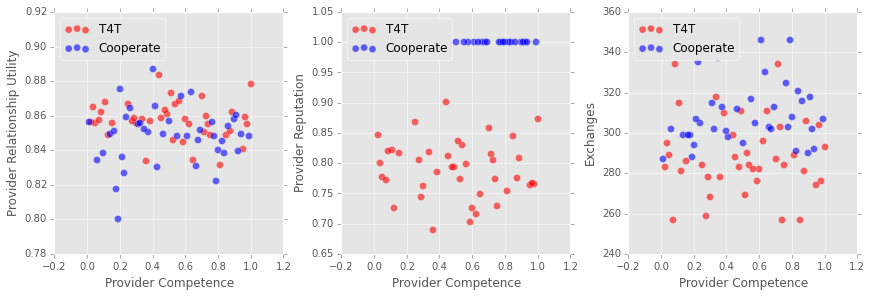

In [64]:
plot_results_by_competence(sim)
#plot_customers(sim)
#plot_providers(sim)